In [ ]:
import keras
from keras.models import Model
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from  matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.layers import  Dropout
from sklearn.model_selection import GridSearchCV
#from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount('/content/drive')
%cd /content/drive/MyDrive/paddy-weed-research

Dataset generation

In [ ]:
train_path = '/content/drive/MyDrive/paddy-weed-research/train_new'
valid_path = '/content/drive/MyDrive/paddy-weed-research/valid'
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(train_path,target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(valid_path, target_size=(224,224),shuffle = False)

Found 2715 images belonging to 3 classes.
Found 175 images belonging to 3 classes.


In [ ]:
#gridsearch_code
def create_model(learn_rate=0.01, momentum=0):
  vggmodel = VGG16(weights='imagenet', include_top=True)
  for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False

  X= vggmodel.layers[-2].output
  X = Dropout(0.6)(X)
  predictions = Dense(3, activation="softmax")(X)
  model_final = Model(inputs = vggmodel.input, outputs = predictions)
  model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])
  #model_final.summary() 
  return model_final

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=70, batch_size=64, verbose=0)
learn_rate = [0.0001, 0.001, 0.01, 0.1, 0.2]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)


Using transfer learning creating the VGG model

In [ ]:
model = VGG16(weights='imagenet', include_top=True)
fc1 = model.layers[-3]
fc2 = model.layers[-2]
#predictions = model.layers[-1]

# Create the dropout layers
dropout1 = Dropout(0.7)
dropout2 = Dropout(0.7)

# Reconnect the layers
x = dropout1(fc1.output)
x = fc2(x)
x = dropout2(x)
predictions=Dense(3, activation="softmax")(x)
#predictors = predictions(x)

# Create a new model
model2 = Model(inputs=model.input, outputs=predictions)
#learning_rate = 0.1
#epochs = 60
#decay_rate = learning_rate / epochs
#model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.8, #decay=decay_rate, nesterov=False), metrics=["accuracy"])
model2.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

model2.summary()

553467904/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Training the model

In [ ]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')
model2.fit(traindata, epochs=60, validation_data= testdata, callbacks=[early])

Epoch 1/60
62/62 [==============================] - 733s 12s/step - loss: 0.9821 - accuracy: 0.6714 - val_loss: 1.1432 - val_accuracy: 0.6293
Epoch 2/60
62/62 [==============================] - 200s 3s/step - loss: 0.5473 - accuracy: 0.8217 - val_loss: 0.6794 - val_accuracy: 0.8276
Epoch 3/60
62/62 [==============================] - 195s 3s/step - loss: 0.2295 - accuracy: 0.9213 - val_loss: 0.4946 - val_accuracy: 0.8448
Epoch 4/60
62/62 [==============================] - 195s 3s/step - loss: 0.1175 - accuracy: 0.9653 - val_loss: 0.6003 - val_accuracy: 0.8276
Epoch 5/60
62/62 [==============================] - 195s 3s/step - loss: 0.0640 - accuracy: 0.9780 - val_loss: 0.5536 - val_accuracy: 0.8793
Epoch 6/60
62/62 [==============================] - 195s 3s/step - loss: 0.0761 - accuracy: 0.9760 - val_loss: 0.7374 - val_accuracy: 0.8103
Epoch 7/60
62/62 [==============================] - 194s 3s/step - loss: 0.0551 - accuracy: 0.9816 - val_loss: 0.8699 - val_accuracy: 0.8362
Epoch 8/60
6

Results:

In [ ]:
Y_pred = model2.predict_generator(testdata)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testdata.classes, y_pred))
print('Classification Report')
target_names = ['Broad-leaved','Grass','Paddy','Sedges']
print(classification_report(testdata.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[21  1  1  0]
 [ 1 34  0  5]
 [ 0  0 20  0]
 [ 0  1  2 30]]
Classification Report
              precision    recall  f1-score   support

Broad-leaved       0.95      0.91      0.93        23
       Grass       0.94      0.85      0.89        40
       Paddy       0.87      1.00      0.93        20
      Sedges       0.86      0.91      0.88        33

    accuracy                           0.91       116
   macro avg       0.91      0.92      0.91       116
weighted avg       0.91      0.91      0.90       116



In [ ]:
print(testdata.class_indices)

{'broad-leaved': 0, 'grass': 1, 'paddy': 2, 'sedges': 3}


In [ ]:
#SET1
#take a batch of dataset 
X,y = testdata.next()
prediction = model2.predict(X)
print(X.shape)
print(y)#truelabel
print(prediction) #predictval

(32, 224, 224, 3)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[[1.00000000e+00 1.13917249e-08 2.70386451e-08 3.06912042e-08]
 [1.00000000e+00 2.07667237e-14 6.12888917e-14 4.35972656e-13]
 [1.00000000e+00 1.38868507e-12 2.03808173e-12 6.56364199e-12]
 [1.00000000e+00 9.93946895e-13 6.52244318e-13 2.08968324e-12]
 [9.99965549e-01 6.28087810e-06 1.56493861e-05 1.24772059e-05]
 [1.00000000e+00 2.25997984e-10 2.73531007e-11 2.93719112e-11]
 [1.00000000e+00 9.35287682e-14 4.05955753e-14 1.61447936e-13]
 [1.00000000e+00 6.00443686e-13 1.22583923e-13 3.64195138e-1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

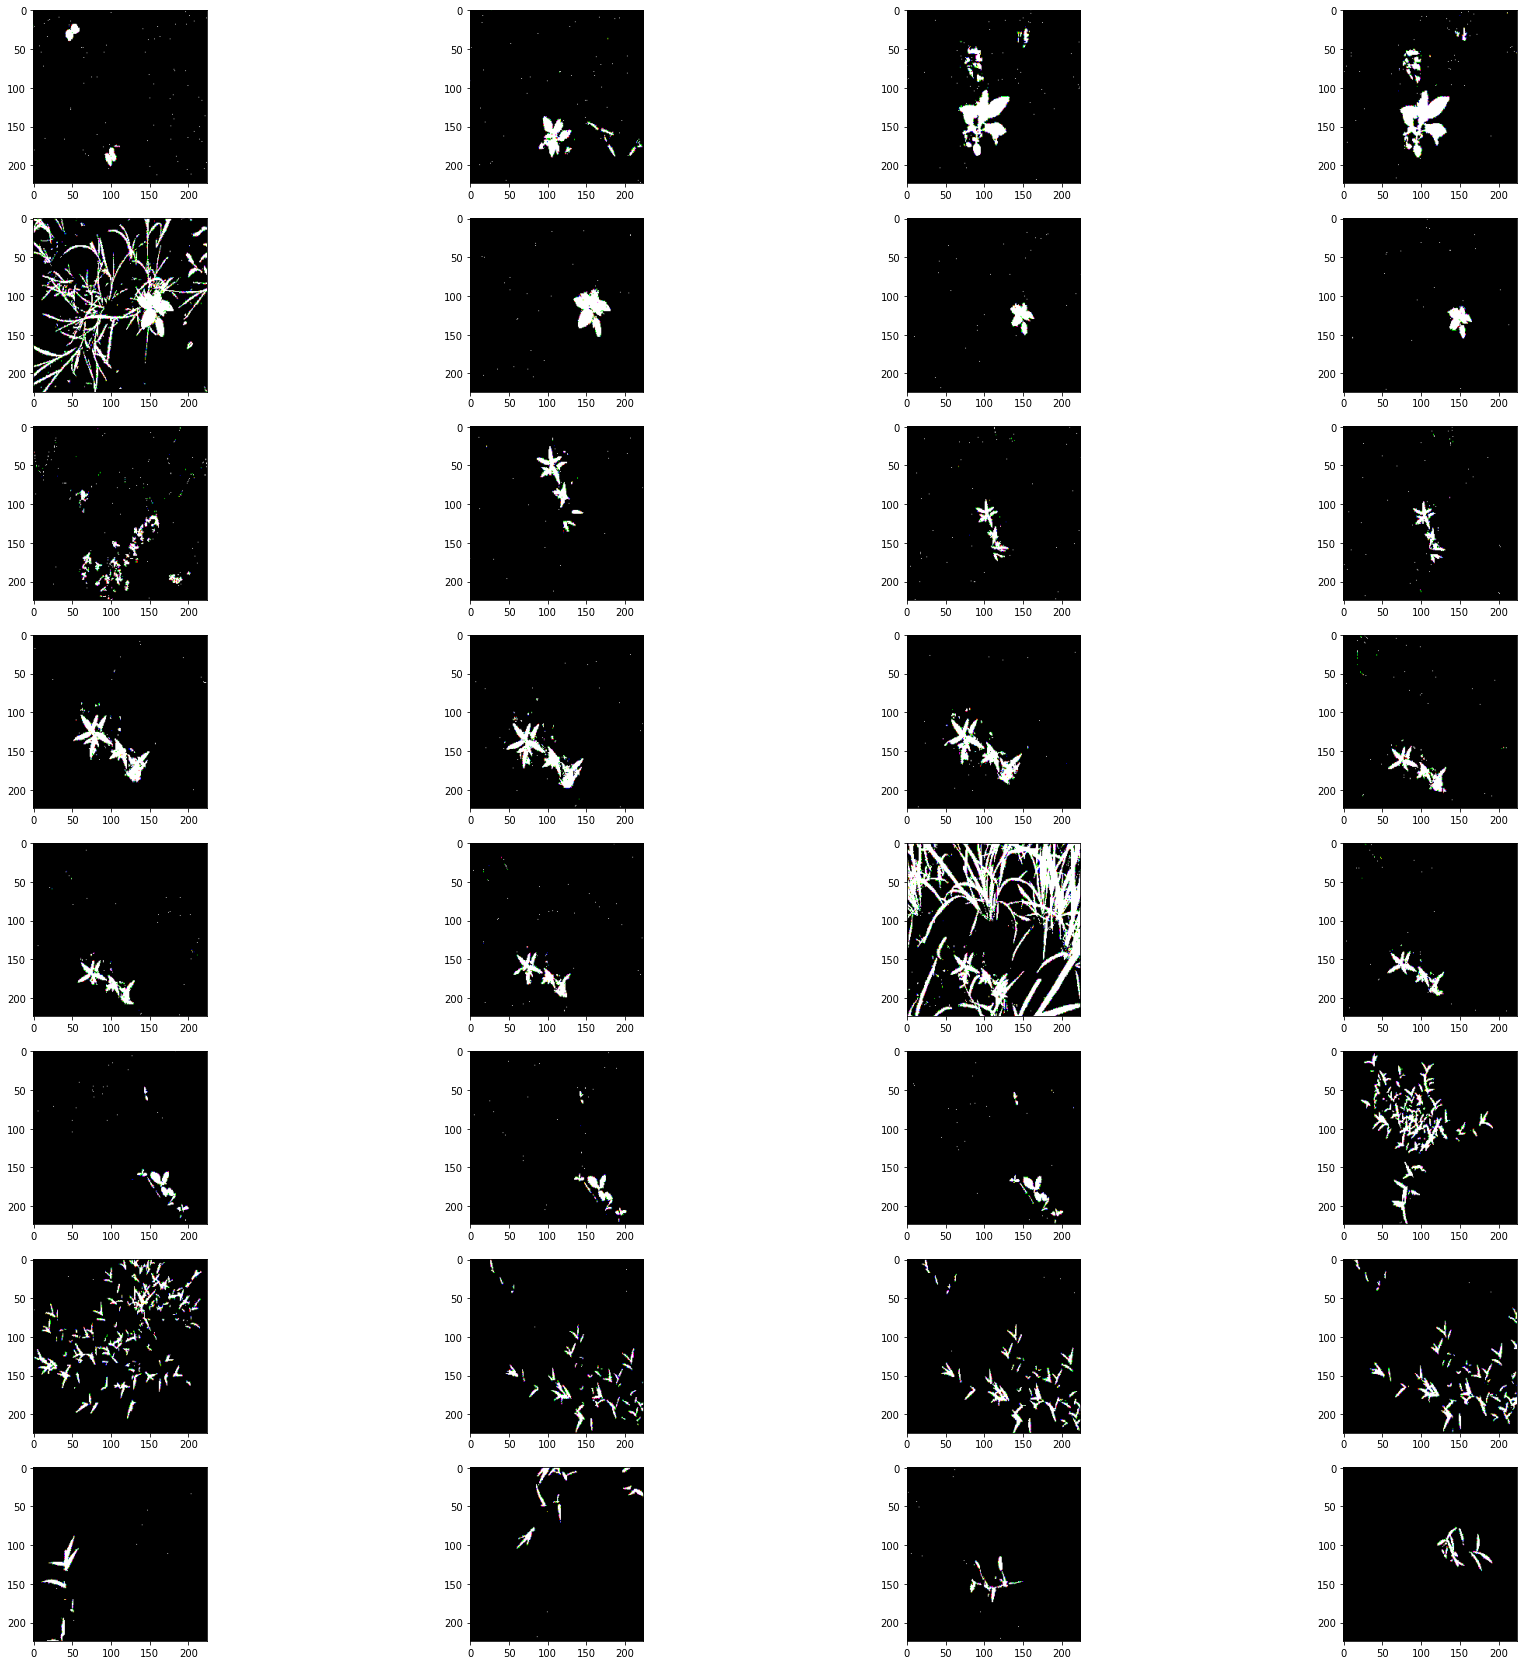

In [ ]:
plt.figure()
f, axarr = plt.subplots(8,4,figsize=(30,30))

k = 0
for i in range (0,8):
  for j in range(0,4):
    axarr[i][j].imshow(X[k])
    k+=1

Classification results by the model

In [ ]:
predicted_val = np.argmax(prediction, axis=1)
print(predicted_val)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 1 1 1 1 1 1 1 0 1]


In [ ]:
#SET2
#take a batch of dataset 
X,y = testdata.next()
prediction = model2.predict(X)
print(X.shape)
print(y)#truelabel
print(prediction) #predictval

(32, 224, 224, 3)
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[[1.05343852e-05 9.99976277e-01 1.25075549e-05 7.24417248e-07]
 [1.22949292e-04 9.99867320e-01 7.76949310e-06 1.93774031e-06]
 [7.92369319e-05 9.99914646e-01 4.78617858e-06 1.27491217e-06]
 [9.41491162e-05 9.99897242e-01 7.05518687e-06 1.47237142e-06]
 [5.51641710e-09 1.00000000e+00 1.07721672e-08 2.76687895e-10]
 [1.40073055e-08 1.00000000e+00 6.36666231e-09 3.71305153e-10]
 [7.05057701e-08 9.99999881e-01 4.84111133e-08 2.57950261e-09]
 [2.87822502e-07 9.99999762e-01 9.32256672e-09 2.89359314e-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

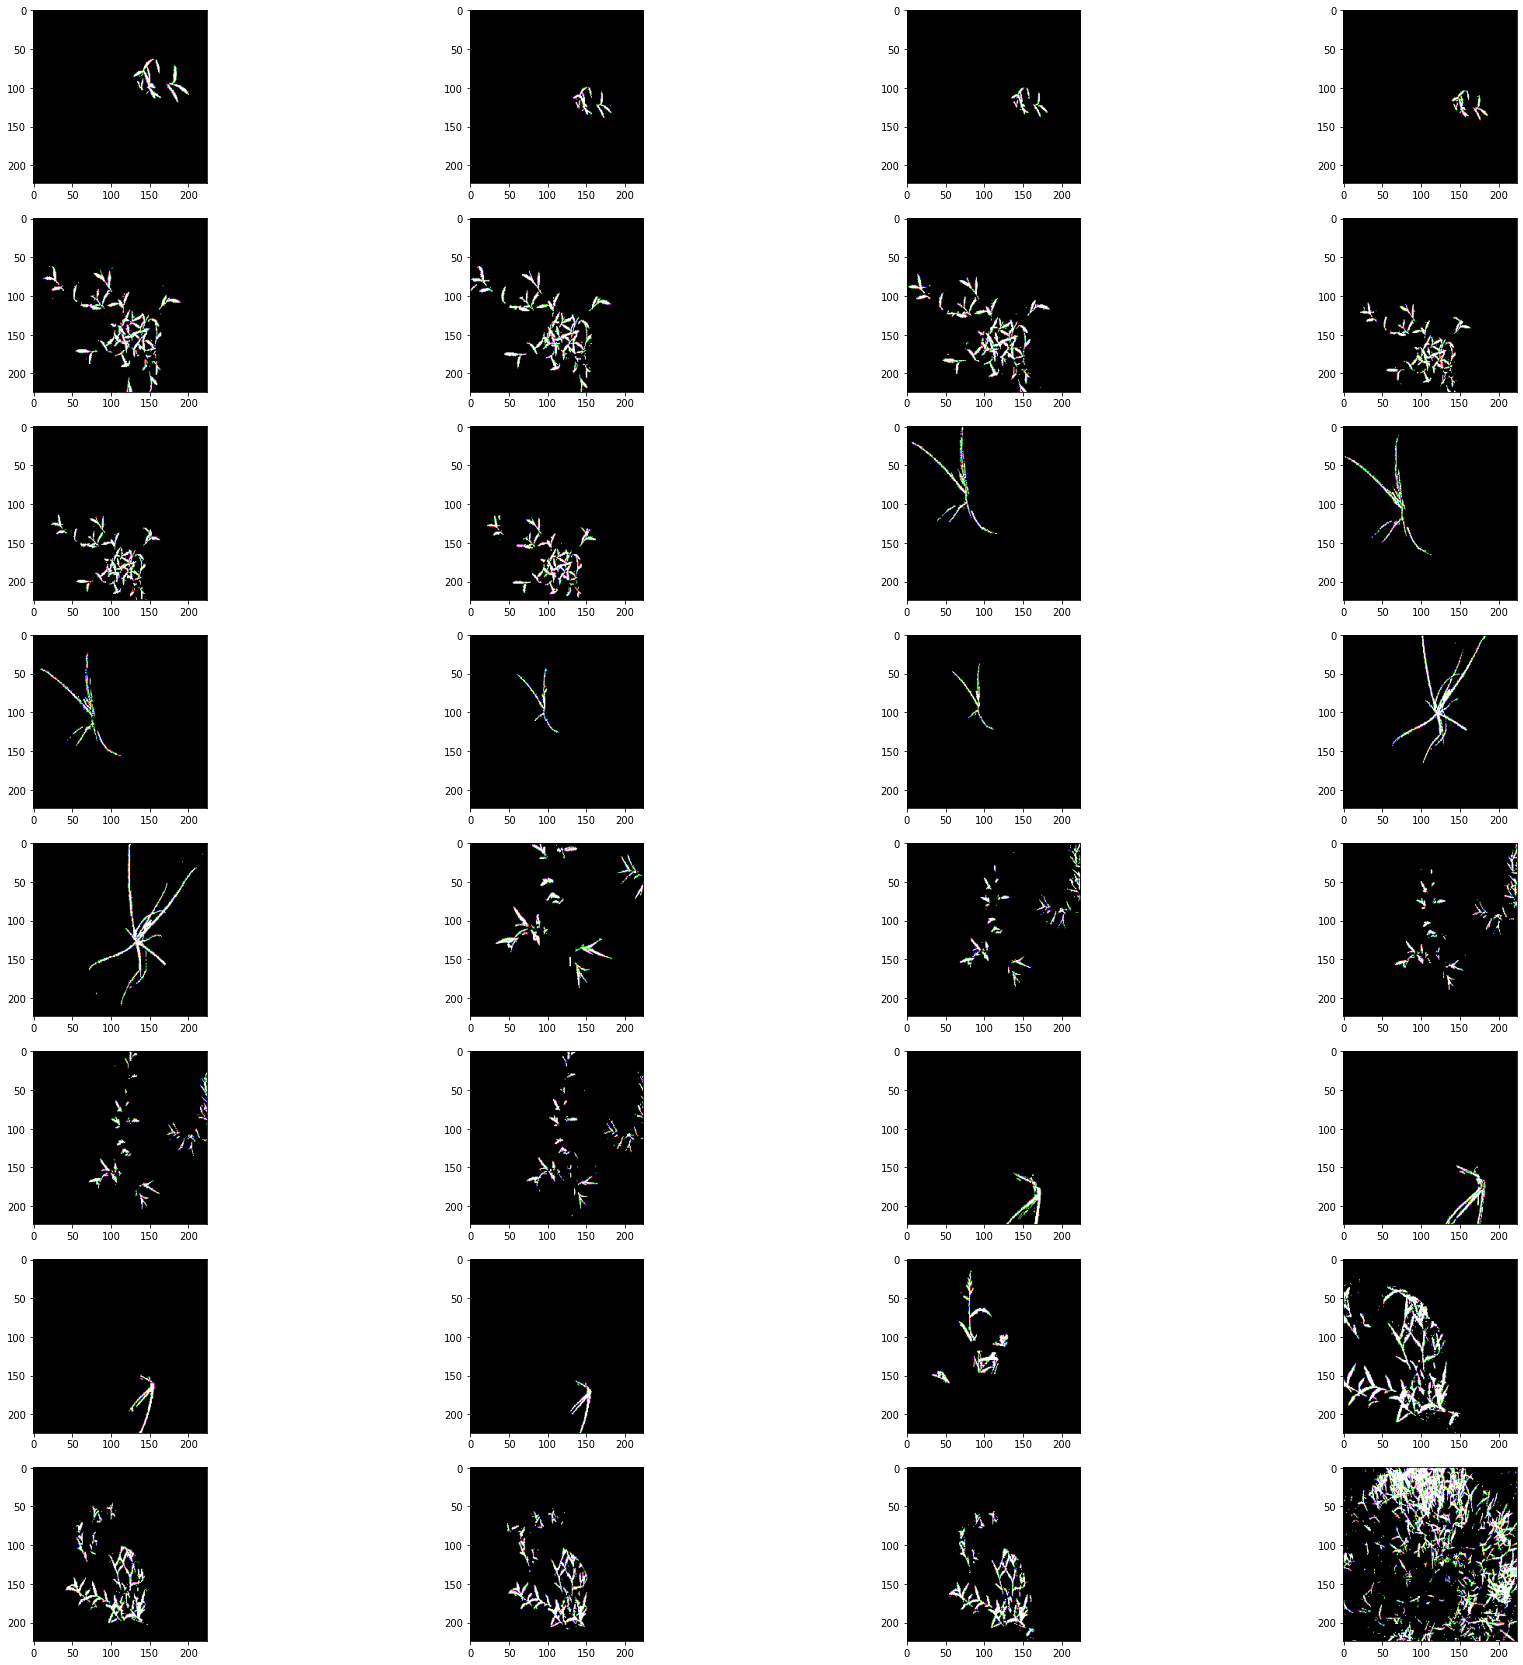

In [ ]:
plt.figure()
f, axarr = plt.subplots(8,4,figsize=(30,30))

k = 0
for i in range (0,8):
  for j in range(0,4):
    axarr[i][j].imshow(X[k])
    k+=1

In [ ]:
predicted_val = np.argmax(prediction, axis=1)
print(predicted_val)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 3 3 3 3 1 1 1 1 1 2]


In [ ]:
#SET4
#take a batch of dataset 
X,y = testdata.next()
prediction = model2.predict(X)
print(X.shape)
print(y)#truelabel
print(prediction) #predictval

(20, 224, 224, 3)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[[3.63579545e-07 1.52446628e-05 1.65223571e-06 9.99982715e-01]
 [2.25048861e-05 1.38608273e-03 3.20197978e-05 9.98559415e-01]
 [2.15812790e-08 3.16555457e-08 1.33938087e-08 1.00000000e+00]
 [3.77233285e-08 3.36877015e-08 1.47327102e-08 9.99999881e-01]
 [2.65613256e-08 9.15983449e-08 2.96237825e-08 9.99999881e-01]
 [4.64100269e-09 2.49474774e-09 1.43915313e-09 1.00000000e+00]
 [6.44905015e-07 1.30198686e-07 6.15465083e-08 9.99999046e-01]
 [3.16033466e-09 4.36765679e-10 8.70005012e-10 1.00000000e+00]
 [7.61811522e-15 4.12938684e-15 2.16836093e-15 1.00000000e+00]
 [8.23221051e-16 9.21106084e-16 1.63685133e-16 1.00000000e+00]
 [1.79007582e-08 2.42925791e-09 2.74476553e-10 1.00

In [ ]:
predicted_val = np.argmax(prediction, axis=1)
print(predicted_val)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 2 3 2]


In [ ]:

#take a batch of dataset 
X,y = testdata.next()
prediction = model2.predict(X)
print(X.shape)
print(y)#truelabel
print(prediction) #predictval

(32, 224, 224, 3)
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[[1.05343852e-05 9.99976277e-01 1.25075549e-05 7.24417248e-07]
 [1.22949292e-04 9.99867320e-01 7.76949310e-06 1.93774031e-06]
 [7.92369319e-05 9.99914646e-01 4.78617858e-06 1.27491217e-06]
 [9.41491162e-05 9.99897242e-01 7.05518687e-06 1.47237142e-06]
 [5.51641710e-09 1.00000000e+00 1.07721672e-08 2.76687895e-10]
 [1.40073055e-08 1.00000000e+00 6.36666231e-09 3.71305153e-10]
 [7.05057701e-08 9.99999881e-01 4.84111133e-08 2.57950261e-09]
 [2.87822502e-07 9.99999762e-01 9.32256672e-09 2.89359314e-0

In [ ]:
predicted_val = np.argmax(prediction, axis=1)
print(predicted_val)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 3 3 3 3 1 1 1 1 1 2]
